In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, RectFace
import glob
import os
import matplotlib.pyplot as plt, matplotlib
from matplotlib.patches import Patch, Rectangle
import matplotlib.gridspec as gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

In [2]:
results = pd.read_csv("kaiju_results.tsv", sep="\t", index_col=0)
results.index.name="Sample"
results.rename(index = lambda x: x.split("_")[0], inplace=True)

In [3]:
def find_cumulative(results, rank="order", cutoff=75):
    x = results.groupby(["Sample",rank]).sum().reset_index()
    cs_t = []
    for sample in x.Sample.unique():
        cs = 0
        for i in x.loc[x.Sample==sample].sort_values("percent", ascending=False).index:
            cs+=x.loc[i,"percent"]
            cs_t.append(x.loc[i,rank])
            if cs>=cutoff:
                break
    return cs_t

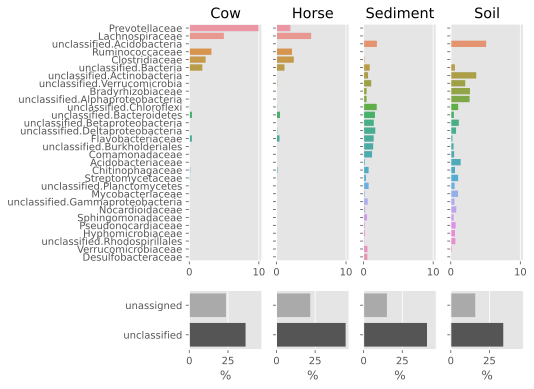

In [4]:
rank = "family"
cs_t = find_cumulative(results, rank=rank, cutoff=75)
plot_taxa = [x for x in set(cs_t) if not x in ["unclassified","unassigned"]]
un_plot_taxa = ["unclassified","unassigned"]
plot_data = results.loc[results[rank].isin(plot_taxa)].groupby(["Sample",rank]).sum().reset_index()
y_order = list(plot_data.groupby(rank).mean().sort_values("percent", ascending=False).index)
un_plot_data = results.loc[results[rank].isin(un_plot_taxa)].groupby(["Sample",rank]).sum().reset_index()

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(6,6), sharey="row", sharex="row", gridspec_kw={'height_ratios': [4, 1]})
ax1 = sns.barplot(data=plot_data.loc[plot_data.Sample=="horse"].set_index(rank).loc[y_order].reset_index(), x="percent", y=rank, ax=axes[0][1])
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title("Horse")
ax2 = sns.barplot(data=un_plot_data.loc[un_plot_data.Sample=="horse"], x="percent", y=rank, ax=axes[1][1], palette="binary")
ax2.set_ylabel("")
ax2.set_xlabel("%")

ax3 = sns.barplot(data=plot_data.loc[plot_data.Sample=="soil"].set_index(rank).loc[y_order].reset_index(), x="percent", y=rank, ax=axes[0][3])
ax3.set_title("Soil")
ax3.set_xlabel("")
ax3.set_ylabel("")
ax4 = sns.barplot(data=un_plot_data.loc[un_plot_data.Sample=="soil"], x="percent", y=rank, ax=axes[1][3], palette="binary")
ax4.set_ylabel("")
ax4.set_xlabel("%")

ax5 = sns.barplot(data=plot_data.loc[plot_data.Sample=="sediment"].set_index(rank).loc[y_order].reset_index(), x="percent", y=rank, ax=axes[0][2])
ax5.set_title("Sediment")
ax5.set_xlabel("")
ax5.set_ylabel("")
ax6 = sns.barplot(data=un_plot_data.loc[un_plot_data.Sample=="sediment"], x="percent", y=rank, ax=axes[1][2], palette="binary")
ax6.set_xlabel("%")
ax6.set_ylabel("");

ax7 = sns.barplot(data=plot_data.loc[plot_data.Sample=="cow"].set_index(rank).loc[y_order].reset_index(), x="percent", y=rank, ax=axes[0][0])
ax7.set_title("Cow")
ax7.set_xlabel("")
ax7.set_ylabel("")
ax8 = sns.barplot(data=un_plot_data.loc[un_plot_data.Sample=="cow"], x="percent", y=rank, ax=axes[1][0], palette="binary")
ax8.set_xlabel("%")
ax8.set_ylabel("");
plt.savefig("Figure3.png".format(rank), dpi=300, bbox_inches="tight")

In [5]:
results.groupby(["Sample","superkingdom"]).sum().drop("taxon_id", axis=1)

percent     reads
Sample   superkingdom                                                    
cow      Archaea                                       0.528728    450943
         Bacteria                                     39.337224  33548915
         Viruses                                       0.059252     50533
         cannot be assigned to a (non-viral) species  23.699770  20212408
         unclassified                                 36.374930  31022448
horse    Archaea                                       0.452503    212513
         Bacteria                                     32.940010  15469334
         Viruses                                       0.049304     23154
         cannot be assigned to a (non-viral) species  21.840815  10256803
         unclassified                                 44.716990  20999827
sediment Archaea                                       1.100081    876306
         Bacteria                                     42.759359  34060595
         Viruses                                       0.106229     84619
         cannot be assigned to a (non-viral) species  15.056604  11993659
         unclassified                                 40.978062  32641949
soil     Archaea                                       0.241296    175919
         Bacteria                                     49.979368  36423846
         Viruses                                       0.037923     27637
         cannot be assigned to a (non-viral) species  15.810943  11522472
         unclassified                                 33.929557  24726697

## Phylogeny

In [6]:
def is_bin(name):
    for t in ["Horse","Cow","Sediment"]:
        if t in name:
            return True
    return False

def is_ref(name):
    for s in ["Probable","Observed","FAE"]:
        if s in name:
            return True
    return False

def parse_leaf(leaf, names, outgroup):
    """
    Parse leaf names, e.g.:
    Q5BCF8_Probable.B_Emericella_nidulans (reference)
    ELA265_Sediment.5_Candidatus.Rhabdochlamydia (bin)
    K5XDZ6_Phanerochaete.carnosa (outgroup)
    """
    try:
        leaf.name = names[(leaf.name).split("_")[0]]
    except KeyError:
        pass
    items = (leaf.name).split("_")
    acc = items[0]
    # If reference sequence
    if is_ref(leaf.name):
        acc, fae_type, genus, species = (leaf.name).split("_")
        #species = species.replace(".",". ")
        species = "{} {}".format(genus, species)
        fae_type = fae_type.replace("FAE.","")
        leaf.add_face(TextFace("({})".format(acc)), column=2, position = "branch-right")
        leaf.add_face(TextFace("({})".format(fae_type)), column=1, position = "branch-right")
        leaf.add_face(TextFace(" {} ".format(species), fstyle="italic"), column=0, position = "branch-right")
        nstyle = NodeStyle(shape="circle", fgcolor="black", size=2)
        leaf.set_style(nstyle)
        leaf.name = ""
    # If bin sequence
    elif is_bin(leaf.name):
        bin_num = items[2]
        tax = " ".join(items[3:])
        tax = tax.replace("."," ")
        leaf.add_face(TextFace(" {} ".format(bin_num), bold=True), column=0, position="branch-right")
        leaf.add_face(TextFace(" {} ".format(tax), fstyle="italic"), column=1, position="branch-right")
        leaf.add_face(TextFace("({})".format(acc)), column=2, position="branch-right")
        nstyle = NodeStyle(shape="circle", fgcolor="red", size=5)
        leaf.set_style(nstyle)
        leaf.name = ""
    elif acc in outgroup:
        acc, genus, species = items
        #genus, species = taxname.split(".")
        species = "{} {}".format(genus, species)
        leaf.add_face(TextFace("({})".format(acc)), column=2, position = "branch-right")
        leaf.add_face(TextFace(" {} ".format(species), fstyle="italic"), column=0, position = "branch-right")
        nstyle = NodeStyle(shape="circle", fgcolor="black", size=2)
        leaf.set_style(nstyle)
        leaf.name = ""
    return len(items)

def parse_internal_node(node):
    nstyle = NodeStyle(fgcolor="black", shape="circle", size=2)
    node.set_style(nstyle)

def get_outgroup_node(t, outgroup):
    r = []
    for leaf in t.get_leaves():
        acc = (leaf.name).split("_")[0]
        if acc in outgroup:
            r.append(leaf.name)
    R = t.get_common_ancestor(r)
    return R
    
def plot_tree(f, out, midpoint=True, outgroup=None, names={}):
    t = Tree(f, format=0)
    if midpoint:
        # Calculate the midpoint node
        R = t.get_midpoint_outgroup()
        t.set_outgroup(R)
    if outgroup:
        R = get_outgroup_node(t, outgroup)
        t.set_outgroup(R)

    # Overall tree style parameters
    ts = TreeStyle()
    ts.show_leaf_name = True
    ts.show_branch_length = False
    ts.show_branch_support = True
    #ts.scale = 20

    for leaf in t.get_leaves():
        leaf = parse_leaf(leaf, names, outgroup)
    for node in t.get_descendants():
        if not node.is_leaf():
            node = parse_internal_node(node)
    t.render(out, tree_style=ts, w=3000, h=4910, dpi=300, units="px")

In [7]:
outgroup=["K5XDZ6","G0RV93", "G2QJR6"]

In [8]:
# Read full names to dictionary
t = Tree("tree_ml_full_name.nwk")
names = {}
for leaf in t.get_leaves():
    names[(leaf.name).split("_")[0]] = leaf.name
names["G2QJR6"] = "G2QJR6_Myceliophthora_thermophil"

In [9]:
plot_tree("tree.ml.clustalo.nwk", "Fig4A.png", outgroup=outgroup, names=names)

In [10]:
plot_tree("tree.nj.clustalo.nwk", "Fig4B.png", outgroup=outgroup, names=names)